In [1]:
import numpy as np
import torch
from pugcn_lib import PUGCN
import os

from tqdm.notebook import tqdm, trange
import open3d as o3d

from utils.data import load_xyz_file
from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss

from utils.viz import viz_many, viz_many_mpl
import matplotlib.pyplot as plt

from omegaconf import OmegaConf


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Jitting Chamfer 3D


/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Loaded JIT 3D CUDA chamfer distance


# Load model

Load a model from checkpoint and evaluate with it 

In [2]:
os.listdir("trained-models/")

['2022-03-15-22-45',
 '.ipynb_checkpoints',
 '2022-03-09-13-08',
 '2022-03-02-17-51',
 '2022-03-09-15-08',
 '2022-03-15-15-48',
 '2022-03-16-09-00']

In [3]:
#d = os.listdir(os.path.join("trained-models"))[0]
ckpt_dir = sorted(os.listdir("trained-models"))[-1]


In [12]:
ckpt_dir

'2022-03-16-09-00'

In [5]:
os.listdir(os.path.join("trained-models", ckpt_dir))

['ckpt_epoch_10', 'ckpt_epoch_1', 'ckpt_epoch_5', 'config.yaml']

In [19]:
exp_conf = OmegaConf.load(os.path.join("trained-models", ckpt_dir, "config.yaml"))
print(exp_conf)

{'name': 'pool_add', 'model_config': {'r': 4, 'k': 20, 'dilations': [1, 2], 'n_idgcn_blocks': 1, 'channels': 24, 'n_dgcn_blocks': 2, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'conv': 'edge', 'pool_type': 'add'}, 'train_config': {'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'eval_every': 5, 'augment': True}, 'data_config': {'path': '../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 1, 'use_randominput': True}}


In [20]:
ckpt_name = "ckpt_epoch_10"

In [21]:
checkpoint = torch.load(os.path.join("trained-models", ckpt_dir, ckpt_name))

In [22]:
history = OmegaConf.create(checkpoint["history"])

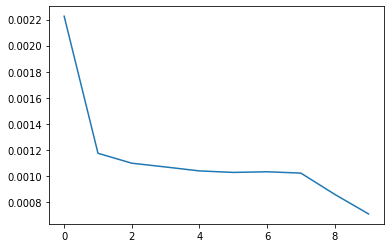

In [23]:
plt.plot(history.train_loss)

In [24]:
model_config = exp_conf.model_config

In [25]:
model_config

{'r': 4, 'k': 20, 'dilations': [1, 2], 'n_idgcn_blocks': 1, 'channels': 24, 'n_dgcn_blocks': 2, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'conv': 'edge', 'pool_type': 'add'}

In [26]:
# model = PUGCN(
#     channels = model_config.channels,
#     k = model_config.k,
#     r = model_config.r,
#     dilations = model_config.dilations,
#     n_idgcn_blocks=model_config.n_idgcn_blocks,
#     n_dgcn_blocks=model_config.n_dgcn_blocks,
#     use_bottleneck = model_config.use_bottleneck,
#     use_pooling = model_config.use_pooling,
#     use_residual = model_config.use_residual
# )

model = PUGCN(**model_config)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

# Qualitative

In [27]:
input_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "input_256")
gt_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "gt_1024")


In [28]:
file = "horse.xyz"
data = load_xyz_file(os.path.join(input_dir, file))
gt = load_xyz_file(os.path.join(gt_dir, file))
data = torch.tensor(data, dtype=torch.float32)
gt = torch.tensor(gt, dtype=torch.float32)

In [29]:
out = model(data).detach()

In [30]:
#o3d
viz_many([data.numpy(), gt.numpy(), out.numpy()]) 

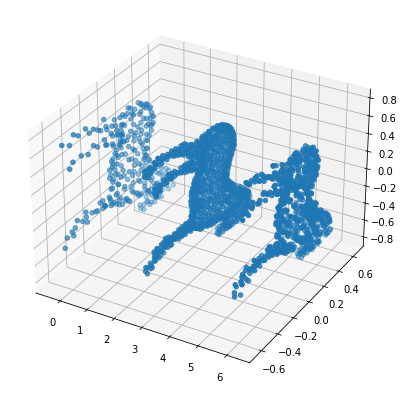

In [31]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection='3d')
viz_many_mpl([data.numpy(), gt.numpy(), out.numpy()], ax=ax) 

# Quantitative

In [32]:
from utils.losses import hausdorff_loss

In [33]:
chamfer_loss = ChamferLoss()

chamfer_losses = []
hausdorff_losses = []
for file in tqdm(os.listdir(input_dir)):
    # Load files
    data = load_xyz_file(os.path.join(input_dir, file))
    gt = load_xyz_file(os.path.join(gt_dir, file))
    data = torch.tensor(data, dtype=torch.float32)
    gt = torch.tensor(gt, dtype=torch.float32)
    #predict
    out = model(data)
    
    #chamfer
    d1, d2, _, _ = chamfer_loss(out.unsqueeze(0).cuda(), gt.unsqueeze(0).cuda())
    loss = d1.mean() + d2.mean()
    chamfer_losses.append(loss.item())
    
    #hausdorff
    
    loss = hausdorff_loss(out.detach(), gt.detach())
    hausdorff_losses.append(loss)
    

  0%|          | 0/127 [00:00<?, ?it/s]

In [34]:
np.mean(chamfer_losses) * 10**3

3.737979700081197

In [35]:
np.mean(hausdorff_losses) * 10**3

114.02914593032753

In [36]:
t = OmegaConf.create(
    {
        "epochs_trained": checkpoint["epoch"],
        "chamfer_loss": float(np.mean(chamfer_losses) * 10**3),
        "hausdorff_loss": float(np.mean(hausdorff_losses) * 10**3),
        "model_size": checkpoint["model_size"],
    }
)

In [41]:
exp_conf

{'name': 'pool_add', 'model_config': {'r': 4, 'k': 20, 'dilations': [1, 2], 'n_idgcn_blocks': 1, 'channels': 24, 'n_dgcn_blocks': 2, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'conv': 'edge', 'pool_type': 'add'}, 'train_config': {'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'eval_every': 5, 'augment': True}, 'data_config': {'path': '../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 1, 'use_randominput': True}, 'results': {'epochs_trained': 10, 'chamfer_loss': 3.737979700081197, 'hausdorff_loss': 114.02914593032753, 'model_size': 25.957}}

In [39]:
results = exp_conf
results.results = t

In [40]:
OmegaConf.save(config=results, f = os.path.join("results", f"results-{ckpt_dir}-{ckpt_name}.yaml"))